In [1]:
# Import required packages
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, img_as_float
import skimage.restoration as skiresort

from skimage.restoration import denoise_wavelet
                                 
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

import numpy as np
import scipy
import os
import pywt

import numbers
from skimage.color import rgb2gray


In [2]:
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.1.0' #path to R installation (not neeeded in all cases)

In [3]:
# To run custom R code
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.rinterface import NULL, NA

# To export data
import pickle 

# For data processing
import pandas as pd

In [4]:
# Define noise level
sigma = 0.02

In [5]:
# Read image
filename = os.path.join('output\\figures\\peppers256.png')
out_path = "output/image-de-noising/"
original_image = io.imread(filename)
image = rgb2gray(original_image)

# Add noise
noisy = random_noise(image, var=sigma**2, seed = 1, mode = "speckle")

# Only look at grey
noisy = rgb2gray(noisy)



<ipython-input-5-ede660943635>:11: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  noisy = rgb2gray(noisy)


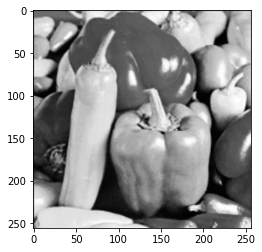

In [6]:
plt.imshow(image, cmap='gray')


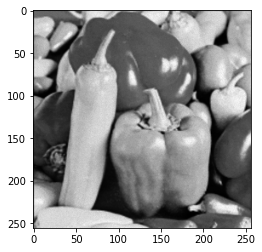

In [7]:
# Image with noise
plt.imshow(noisy, cmap='gray')


In [8]:
# Define R functions
itses = importr('itses') # For SparseMAD() as itses()
r_sparse_mad = robjects.r['sparse.mad.estimator']

r_source = robjects.r['source']
r_source("R-utility/extra-utility.R")
est_ss  = robjects.r['get.sureshrink.threshold']
est_iterative = robjects.r['itses_saved_speckle_custom']


In [10]:
# Define custom thresholding functions
const = 1
# Iterative estimation with soft threshold starting at median
def itses_st(x, ones, sd, store_iterations = True, name = None):
    shape = x.shape
    x = np.ndarray.flatten(x)
    
    ones = np.ndarray.flatten(ones/const)
    print(ones)

    savepath = NULL
    if name: 
        savepath = "output/image-de-noising/wavelets-st/" + name + str(len(x)) + ".RData"
    
    x_vec = FloatVector(x)
    ones_vec = FloatVector(ones)
    sd_vec = FloatVector([sd])
    result = est_iterative(x_vec, 
                           ones = ones_vec,
                             sd = sd_vec,
                             savepath = savepath,
                             debug = True,
                              b = 200,
                              m = 10,
                              k = 50)
    print(result[1])
    return np.reshape(np.array(result[0]), shape)

# Run SureShrink from R package ASUS.
def ss(x, sd):
    x = np.ndarray.flatten(x)
    z = x/sd
    z_vec = FloatVector(z)
    threshold = est_ss(z_vec)[0]
    return threshold*sd

# Estiamte noise with SparseMAD
def sparse_mad (detail_coeffs, distribution='Gaussian'):
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    if distribution.lower() != 'gaussian':
        raise ValueError("Only Gaussian noise estimation is currently "
                         "supported")
        
    x = np.ndarray.flatten(detail_coeffs)
    x_vec = FloatVector(x)
    sigma = r_sparse_mad(x_vec, debug = True)[0]
    return sigma


In [15]:
# Implement custom wavelet denoising based on scikit-image, mostly copy paste from scikit-image source code. 
# scikit-imaage source code can be found at e.g. https://github.com/scikit-image/scikit-image
# New custom code will be higlighted
def _sigma_est_dwt(detail_coeffs, distribution='Gaussian'):
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    if distribution.lower() == 'gaussian':
        # 75th quantile of the underlying, symmetric noise distribution
        denom = scipy.stats.norm.ppf(0.75)
        sigma = np.median(np.abs(detail_coeffs)) / denom
    else:
        raise ValueError("Only Gaussian noise estimation is currently "
                         "supported")
    return sigma

def _scale_sigma_and_image_consistently(image, sigma, multichannel,
                                        rescale_sigma):
    if multichannel:
        if isinstance(sigma, numbers.Number) or sigma is None:
            sigma = [sigma] * image.shape[-1]
        elif len(sigma) != image.shape[-1]:
            raise ValueError(
                "When multichannel is True, sigma must be a scalar or have "
                "length equal to the number of channels")
    if image.dtype.kind != 'f':
        if rescale_sigma:
            range_pre = image.max() - image.min()
        image = img_as_float(image)
        if rescale_sigma:
            range_post = image.max() - image.min()
            # apply the same magnitude scaling to sigma
            scale_factor = range_post / range_pre
            if multichannel:
                sigma = [s * scale_factor if s is not None else s
                         for s in sigma]
            elif sigma is not None:
                sigma *= scale_factor
    elif image.dtype == np.float16:
        image = image.astype(np.float32)
    return image, sigma
def _bayes_thresh(details, var):
    """BayesShrink threshold for a zero-mean details coeff array."""
    # Equivalent to:  dvar = np.var(details) for 0-mean details array
    dvar = np.mean(details*details)
    eps = np.finfo(details.dtype).eps
    thresh = var / np.sqrt(max(dvar - var, eps))
    return thresh
def _universal_thresh(img, sigma):
    """ Universal threshold used by the VisuShrink method """
    return sigma*np.sqrt(2*np.log(img.size))


def _wavelet_threshold(image, wavelet, method='IterativeST', threshold=None,
                       sigma=None, mode='soft', wavelet_levels=None, use_sparse_mad_estimation = False, name = None):
    # Note that arguments of _wavelet_threshold is slightly altered from original

    wavelet = pywt.Wavelet(wavelet)

    original_extent = tuple(slice(s) for s in image.shape)

    # Determine the number of wavelet decomposition levels
    if wavelet_levels is None:
        # Determine the maximum number of possible levels for image
        dlen = wavelet.dec_len
        wavelet_levels = pywt.dwtn_max_level(image.shape, wavelet)

        # Skip coarsest wavelet scales (see Notes in docstring).
        wavelet_levels = max(wavelet_levels - 3, 1)

    coeffs = pywt.wavedecn(image, wavelet=wavelet, level=wavelet_levels)
    ones = pywt.wavedecn(const*np.ones(image.shape), wavelet=wavelet, level=wavelet_levels)
    # Detail coefficients at each decomposition level
    dcoeffs = coeffs[1:]
    dones = ones[1:]
    
    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Add the option of using SparseMAD noise estimation (done across all bands in)
    if sigma is None:
        # Estimate the noise via the method in [2]_
        detail_coeffs = dcoeffs[-1]['d' * image.ndim]
        print("Number of points in noise estimation:", len(detail_coeffs))
        if not use_sparse_mad_estimation:
            sigma = _sigma_est_dwt(detail_coeffs, distribution='Gaussian') 
        else: 
            sigma = sparse_mad(detail_coeffs, distribution='Gaussian') 
        print("Estimated noise:", sigma)
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    if method is not None and threshold is not None:
        warn(("Thresholding method {} selected.  The user-specified threshold "
              "will be ignored.").format(method))
        
    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Output the wavelet coefficitnes to study in R (before thresholding)
    if name:
        print("Storing waves")
        data = dcoeffs[len(dcoeffs)-2]
        data = np.array([np.ndarray.flatten(data[level]) for level in data])
        data = np.transpose(data)  
        np.savetxt(out_path + name + ".csv", data, delimiter=",")
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    if threshold is None:
        print(sigma)
        var = sigma**2
        if method is None:
            raise ValueError(
                "If method is None, a threshold must be provided.")
        elif method == "BayesShrink":
            # The BayesShrink thresholds from [1]_ in docstring
            threshold = [{key: _bayes_thresh(level[key], var) for key in level}
                         for level in dcoeffs]
        elif method == "VisuShrink":
            # The VisuShrink thresholds from [2]_ in docstring
            threshold = _universal_thresh(image, sigma)
        #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        ## Injecting custom thresholding methods, ITSES-ST, ITSES-HT, and SureShrink
        elif method == "IterativeST":
            denoised_detail = []
            if name:
                for k in range(len(dcoeffs)):
                    denoised_detail += [{key: itses_st(dcoeffs[k][key], dones[k][key], sigma, name = name+key) 
                                         for key in dcoeffs[k]}]
            else:
                for k in range(len(dcoeffs)):
                    denoised_detail += [{key: itses_st(dcoeffs[k][key], dones[k][key],  sigma, name = None) 
                                         for key in dcoeffs[k]}]
                threshold = "A"
        elif method == "SureShrink":
            threshold = [{key: ss(level[key], sigma) for key in level}
                         for level in dcoeffs]
        #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        else:
            raise ValueError("Unrecognized method: {}".format(method))
            
            
    #!! Custom Code Start !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Print found thresholds for debugging
    #!! Custom Code End !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
   
       
    if method != "IterativeST":
        if np.isscalar(threshold):        
            denoised_detail = [{key: pywt.threshold(level[key],
               f                                     value=threshold,
                                                    mode=mode) for key in level}
                               for level in dcoeffs]
        else:        
            denoised_detail = [{key: pywt.threshold(level[key],
                                                    value=thresh[key],
                                                    mode=mode) for key in level}
                               for thresh, level in zip(threshold, dcoeffs)]
    denoised_coeffs = [coeffs[0]] + denoised_detail
    return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]
def denoise_wavelet(image, sigma=None, wavelet='db1', mode='soft',
                    wavelet_levels=None, multichannel=False,
                    convert2ycbcr=False, method='BayesShrink',
                    rescale_sigma=True, *, channel_axis=None,
                   use_sparse_mad_estimation = False, name = None):
    multichannel = channel_axis is not None


    # floating-point inputs are not rescaled, so don't clip their output.
    clip_output = image.dtype.kind != 'f'

    if convert2ycbcr and not multichannel:
        raise ValueError("convert2ycbcr requires multichannel == True")

    image, sigma = _scale_sigma_and_image_consistently(image,
                                                       sigma,
                                                       multichannel,
                                                       rescale_sigma)
    
    if multichannel:
        if convert2ycbcr:
            out = color.rgb2ycbcr(image)
            # convert user-supplied sigmas to the new colorspace as well
            if rescale_sigma:
                sigma = _rescale_sigma_rgb2ycbcr(sigma)
            for i in range(3):
                # renormalizing this color channel to live in [0, 1]
                _min, _max = out[..., i].min(), out[..., i].max()
                scale_factor = _max - _min
                if scale_factor == 0:
                    # skip any channel containing only zeros!
                    continue
                channel = out[..., i] - _min
                channel /= scale_factor
                sigma_channel = sigma[i]
                if sigma_channel is not None:
                    sigma_channel /= scale_factor
                out[..., i] = denoise_wavelet(channel,
                                              wavelet=wavelet,
                                              method=method,
                                              sigma=sigma_channel,
                                              mode=mode,
                                              wavelet_levels=wavelet_levels,
                                              rescale_sigma=rescale_sigma)
                out[..., i] = out[..., i] * scale_factor
                out[..., i] += _min
            out = color.ycbcr2rgb(out)
        else:
            out = np.empty_like(image)
            for c in range(image.shape[-1]):
                print("Thresholding color: ", c)
                print("Shape", np.shape(image[..., c]))
                if(name):
                    name = name+"channel_"+str(c)
                out[..., c] = _wavelet_threshold(image[..., c],
                                                 wavelet=wavelet,
                                                 method=method,
                                                 sigma=sigma[c], mode=mode,
                                                 wavelet_levels=wavelet_levels,
                                                use_sparse_mad_estimation =use_sparse_mad_estimation, 
                                                name = name)
    else:
        out = _wavelet_threshold(image, wavelet=wavelet, method=method,
                                 sigma=sigma, mode=mode,
                                 wavelet_levels=wavelet_levels,
                                use_sparse_mad_estimation = use_sparse_mad_estimation, 
                                 name = name)

    if clip_output:
        clip_range = (-1, 1) if image.min() < 0 else (0, 1)
        out = np.clip(out, *clip_range, out=out)
    return out

In [16]:
# Run deafault methods 
bayes_image= denoise_wavelet(noisy, method ="BayesShrink", multichannel = True)
visu_image = denoise_wavelet(noisy, method ="VisuShrink", multichannel = True)


Number of points in noise estimation: 128
Estimated noise: 0.011225306866044744
0.011225306866044744
Number of points in noise estimation: 128
Estimated noise: 0.011225306866044744
0.011225306866044744


In [17]:
# Storing the original wavelet coefficients
try:
    _ = denoise_wavelet(image, method ="DONOTHING", name = "original_wavelets", multichannel = False)
except:
    print("")

Number of points in noise estimation: 128
Estimated noise: 0.004805084719544886
Storing waves
0.004805084719544886



In [18]:
%%time 
itses_image_st = denoise_wavelet(noisy, method ="IterativeST", use_sparse_mad_estimation = False, name = "stjerten_st_", multichannel = False, sigma = sigma)


Storing waves
0.02
[ 1.95711114  1.7050939  -0.31997822 -0.0977042  -0.99194525 -0.50829782
 -0.02900146 -2.73799584  3.67323454  1.26038951 -1.90248643 -0.21736795
 -0.92545234 -1.18156945  0.14532116 -1.04366019  3.88573758  0.38356314
 -0.8427191  -1.85202626 -1.285785   -0.14039135 -5.99520282  1.31859735
  2.03007743 -6.74904392 -0.86802413 -1.03649388 -0.26010926 -0.26378812
 -3.49022351  1.96823483  0.34393385 -6.17637809  3.57305696 -0.21070715
 -1.21871511 -1.34978896  8.91238958 -2.32735979 -1.35549122 -4.20461761
  6.5561946  -0.65892896  0.18479204 -1.64147052  7.49915252 -1.33374999
  3.48276519 -2.48331413  8.52966571 -2.73955183  0.8636484  -2.2455841
  5.11902695 -0.87465435  0.37325879 -0.74701754  2.00472434  1.40433658
  1.2219364  -2.80925395 -2.7664489   0.79418721]
[1] 1.000479

[-2.29958921 -1.14015388  3.88298785  0.88258479  4.9136436  -1.75370823
  0.13861944  0.17799872  2.47615976 -0.81762959 -1.33155459 -0.47054502
 -0.84934746  2.39901946 -0.27033846 -2.02

[ 2.55814863e-01 -1.41098668e+00 -6.83203350e-01  5.03900323e-01
 -6.40225212e-01  2.63687810e-01  4.12728158e-01  2.56089530e-02
  7.63973840e-01 -8.20008123e-01  1.42962773e-02  4.81943150e-01
 -4.26134445e-01  8.72707019e-02  2.74753632e-01 -1.61583307e-01
  5.90248464e-02  1.89671203e+00  6.56916863e-03  2.93662391e-01
 -1.16170276e-02  1.08314253e+00 -5.09296908e-03 -6.83872689e-02
 -4.02451794e-02 -2.63551916e-01  2.76500054e-01  2.55030236e-02
 -1.02210286e-01 -1.28526669e+00  1.32122276e-01  5.79557449e-02
  9.43948913e-02 -7.37337397e-01  2.30575481e+00 -1.72272193e-01
  2.89021408e-01 -1.10172335e+00  2.62646738e-02  1.17896392e-02
 -6.47965207e-03 -1.33311571e-03 -8.49297030e-01  3.14618984e-01
 -4.57065040e-01  1.31180470e+00 -1.15483866e+00 -4.99947681e-02
 -8.46795830e-02 -1.01336190e+00 -1.22776779e+00  2.38668219e-02
  1.21486610e-01 -3.66224264e-01 -8.61060635e-02  2.09888278e-01
  1.70565039e-02  1.34186121e+00 -9.59175272e-01 -5.83009919e-01
  5.65296150e-01  2.17183

In [66]:
%%time 
# Run sure shrink denosing
ss_image= denoise_wavelet(noisy, method ="SureShrink", use_sparse_mad_estimation = False, multichannel = False, sigma = sigma)

0.02
Wall time: 13.3 ms


In [67]:
plt.rcParams.update({'font.size': 28})

In [68]:
sigma

0.02

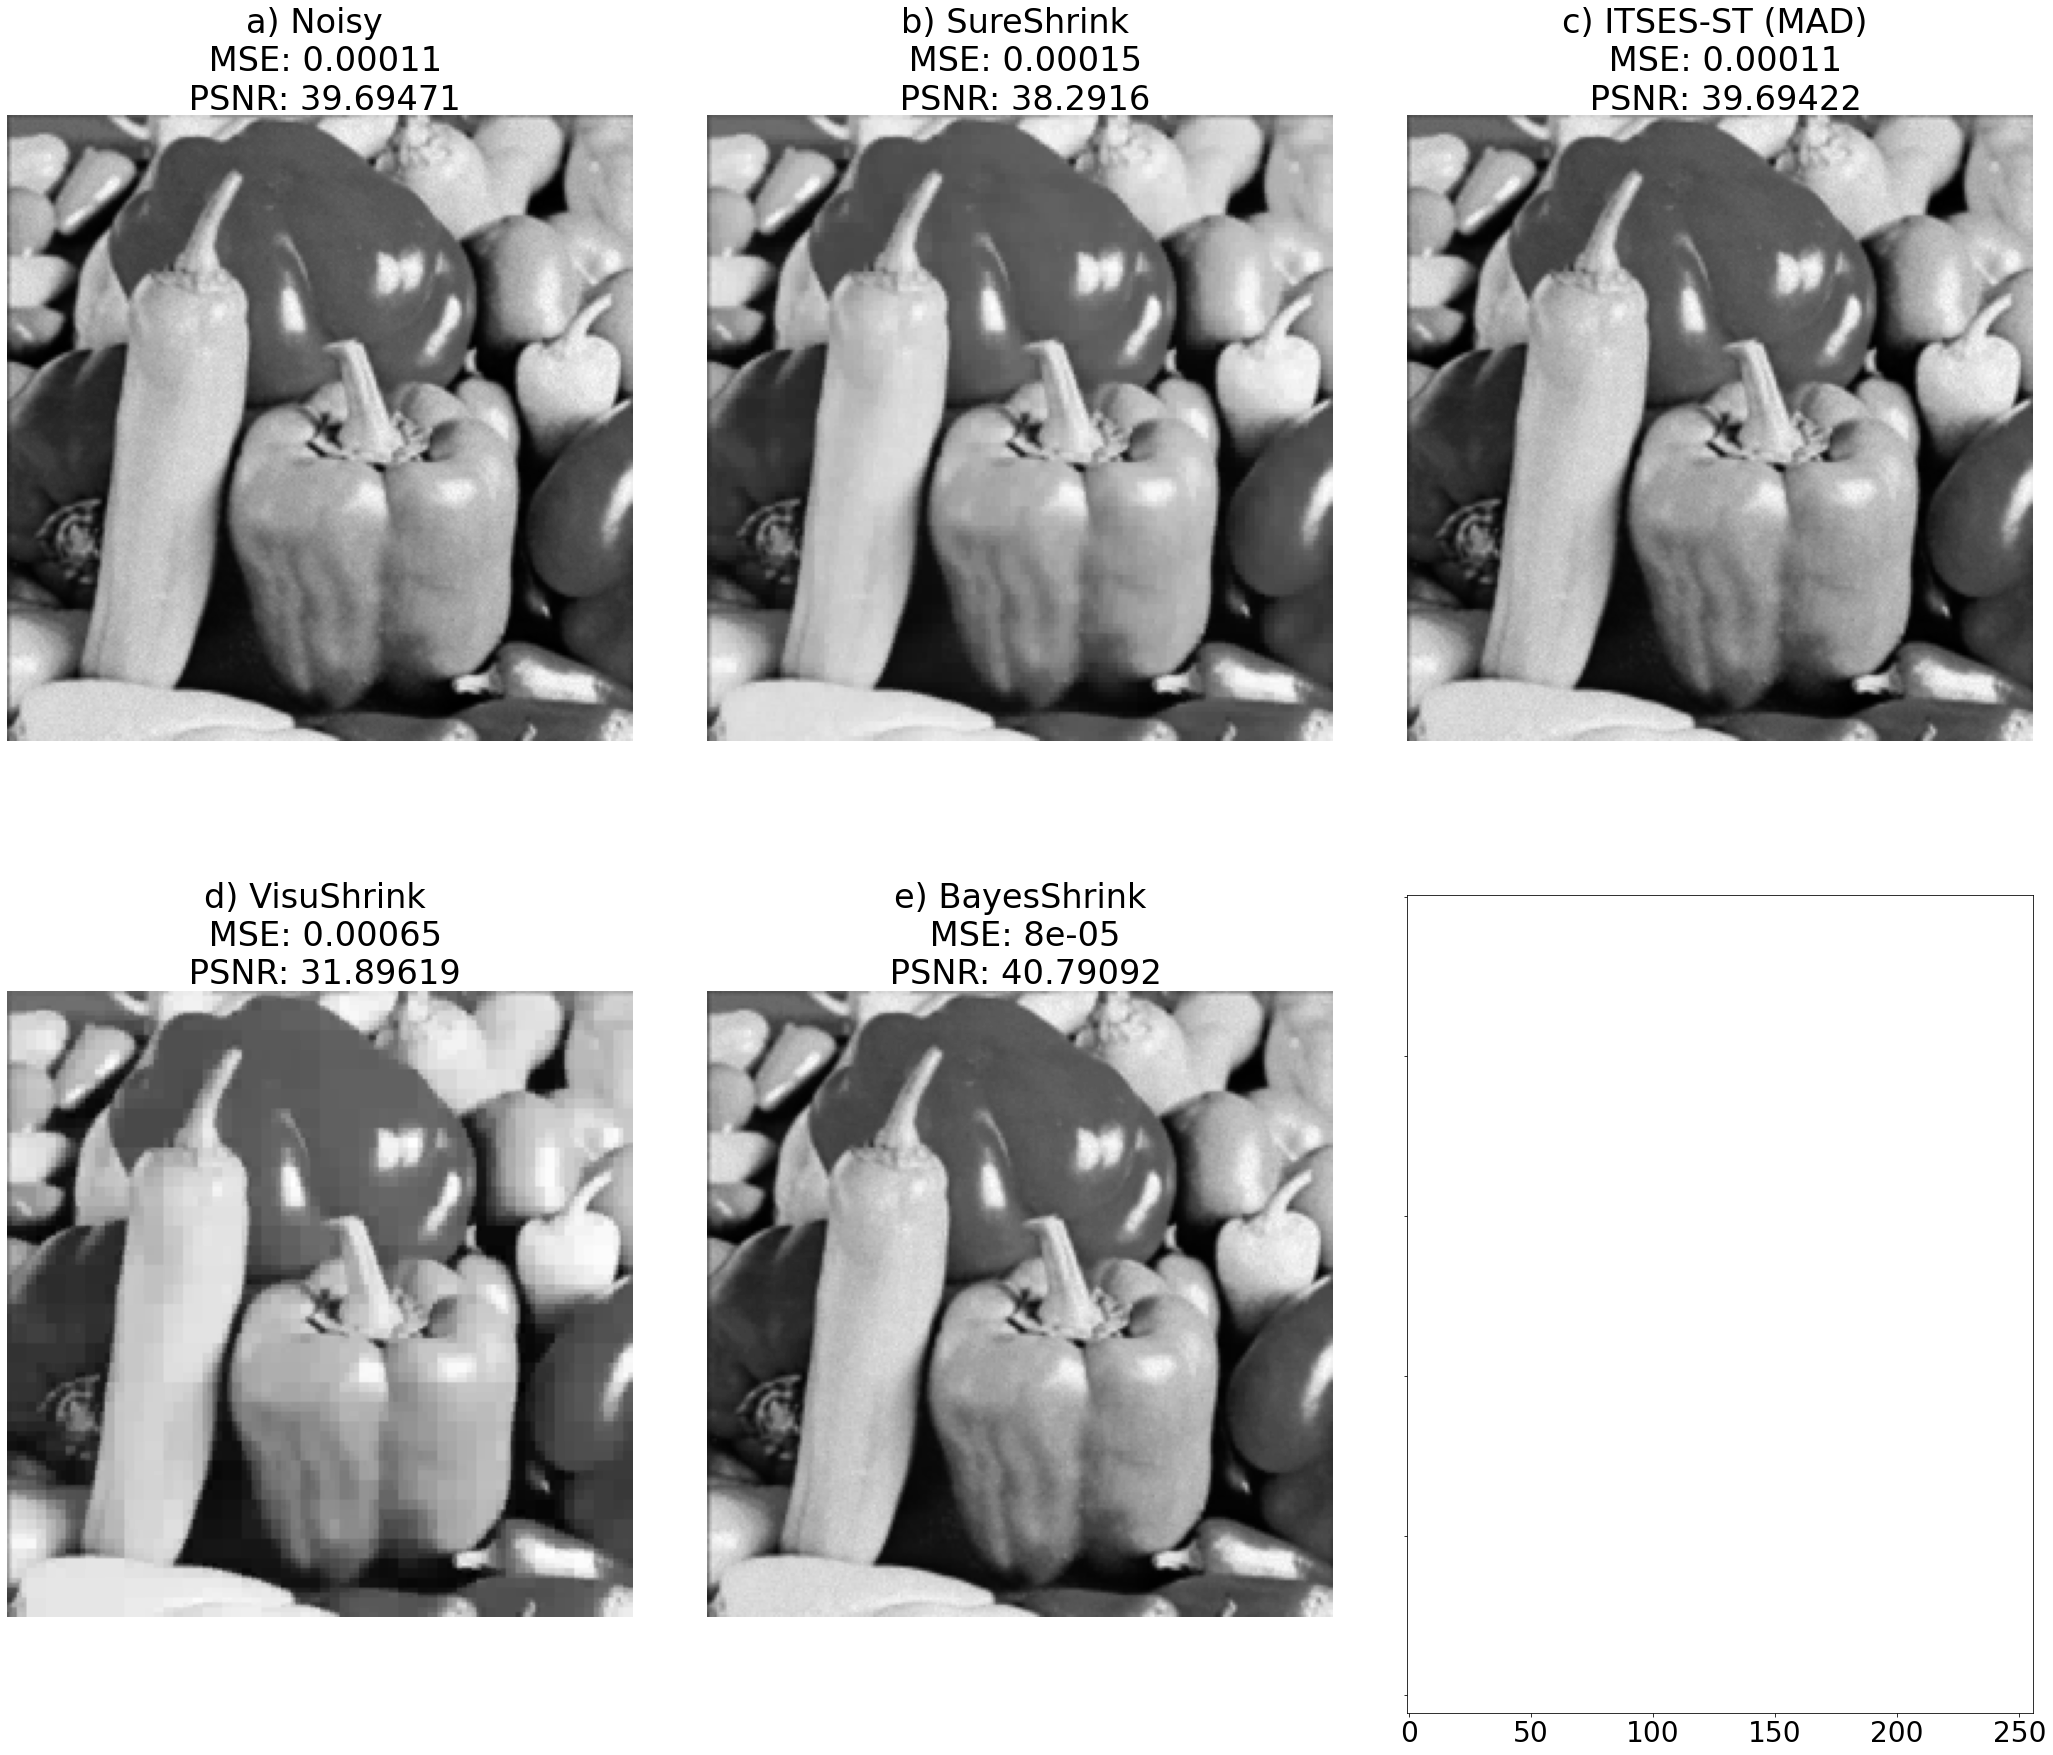

In [69]:
# Plot data
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 25),
                       sharex=True, sharey=True)
fig.tight_layout()
plt.gray()


psnr = str(round(peak_signal_noise_ratio(image, noisy),5))
mse = str(round(mean_squared_error(image, noisy),5))
ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('a) Noisy \n MSE: '+ mse + "\n PSNR: " + psnr)


psnr = str(round(peak_signal_noise_ratio(image, visu_image),5))
mse = str(round(mean_squared_error(image, visu_image),5))
ax[1, 0].imshow(visu_image)
ax[1, 0].axis('off')
ax[1, 0].set_title('d) VisuShrink \n MSE: '+ mse + "\n PSNR: " + psnr)

psnr = str(round(peak_signal_noise_ratio(image, bayes_image),5))
mse = str(round(mean_squared_error(image, bayes_image),5))
ax[1, 1].imshow(bayes_image)
ax[1, 1].axis('off')
ax[1, 1].set_title('e) BayesShrink\n MSE: '+ mse + "\n PSNR: " + psnr)

psnr = str(round(peak_signal_noise_ratio(image, ss_image),5))
mse = str(round(mean_squared_error(image, ss_image),5))
ax[0, 1].imshow(ss_image)
ax[0, 1].axis('off')
ax[0, 1].set_title('b) SureShrink \n MSE: '+ mse + "\n PSNR: " + psnr)


psnr = str(round(peak_signal_noise_ratio(image, itses_image_st),5))
mse = str(round(mean_squared_error(image, itses_image_st),5))
ax[0, 2].imshow(itses_image_st)
ax[0, 2].axis('off')
ax[0, 2].set_title('c) ITSES-ST (MAD) \n MSE: '+ mse + "\n PSNR: " + psnr)



plt.savefig("output/figures//cat_large.pdf")

plt.show()

In [40]:
x_vec = FloatVector([1.2, 1.3])
sd_vec = FloatVector([0.3])
threshold = est_iterative(x_vec, 
                         sd = sd_vec,
                         savepath = "test",
                         debug = True,
                          b = 200,
                          m = 10,
                          k = 500
                        )[0]

In [41]:
np.array(threshold)

array([1.48195088, 1.05266647])

In [54]:
a = pywt.wavedecn(image, wavelet='db1', level=None)[1:]
b = pywt.wavedecn(3*image, wavelet='db1', level=None)[1:]
c = pywt.wavedecn(4*image, wavelet='db1', level=None)[1:]
allPassed = True
for k in range(len(a)):
    for key in  a[k]:
        if not np.allclose(c[k][key], a[k][key] + b[k][key]):
            print(k, key,c[k][key] != a[k][key] + b[k][key])
            allPassed = False
allPassed

True